In [1]:
modelName = 'densenet201'
filterName = 'normalize'

point = 'Point1'

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os, sys

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [7]:
def createDataFrame():
    
    train_df = pd.read_csv('../../data/train.csv')
    train_df['img_path'] = '../../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../../data/test.csv')
    test_df['img_path'] = '../../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [8]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [9]:
df = createDataFrame()

In [10]:
model = models.densenet201(pretrained=True)

model.classifier = torch.nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)


weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=150, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=30, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device).float().reshape(-1, 1)

            y_predict = model(X)
            
            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 0 / 15 | Train loss: 0.02631360662859831 | Val loss: 0.007704851173912175
Epoch: 1 / 15 | Train loss: 0.00770208636349269 | Val loss: 0.006009081381657429
Epoch: 2 / 15 | Train loss: 0.005260339192274666 | Val loss: 0.004339123451035658
Epoch: 3 / 15 | Train loss: 0.004316715686126186 | Val loss: 0.004644052117048257
Epoch: 4 / 15 | Train loss: 0.0033468916801474877 | Val loss: 0.004240728196691634
Epoch: 5 / 15 | Train loss: 0.003269151607051447 | Val loss: 0.003881858382625908
Epoch: 6 / 15 | Train loss: 0.0025437738791462988 | Val loss: 0.0038402523178914494
Epoch: 7 / 15 | Train loss: 0.0023609117710162012 | Val loss: 0.0035807360550279554
Epoch: 8 / 15 | Train loss: 0.0016754414534798671 | Val loss: 0.0036437505876585
Epoch: 9 / 15 | Train loss: 0.0016742778010754033 | Val loss: 0.004205459802401142
Epoch: 10 / 15 | Train loss: 0.0018169478995135372 | Val loss: 0.0037578158533051464
Epoch: 11 / 15 | Train loss: 0.0021067681744784475 | Val loss: 0.004703891600893957
Epoch: 1

13


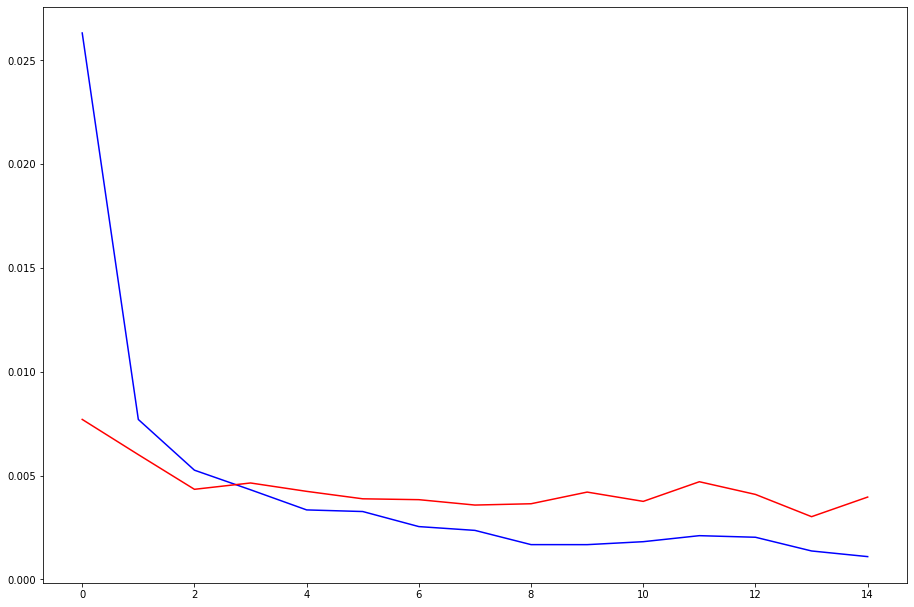

In [12]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [13]:
model = models.densenet201(pretrained=True)

model.classifier = torch.nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=30, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 18min 39s


In [15]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [16]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename        model     filter   point  \
0       033e9640-dabe-47a6-8777-4fbc03aca97e  densenet201  normalize  Point1   
1       60474c1f-00db-4c7e-bd52-adf857b7eb41  densenet201  normalize  Point1   
2       16c2ab7b-5baf-4c5b-b7db-3f651fd3bb3c  densenet201  normalize  Point1   
3       0557c9c1-5180-4cab-9b3d-848292c15163  densenet201  normalize  Point1   
4       f32542a0-8f55-4414-b071-aa5abe363e3c  densenet201  normalize  Point1   
...                                      ...          ...        ...     ...   
528315  b97738f6-cc0a-425f-b81d-c5407d18d9ab  densenet201  normalize  Point1   
528316  f78d4e46-f061-4c40-9d13-280f3b84f9de  densenet201  normalize  Point1   
528317  3611ad0a-c36d-41be-a80e-2df69235f2de  densenet201  normalize  Point1   
528318  e720accb-ce97-4245-bb86-12604541f3d3  densenet201  normalize  Point1   
528319  ae242a1d-9ba7-4526-bb04-f6b49cfe0da5  densenet201  normalize  Point1   

        v   predict  sign  
0       0  0.000072  -1.0  
1       0  0.000072  -1.0  
2       0  0.000091  -1.0  
3       0  0.000078  -1.0  
4       0  0.000090  -1.0  
...    ..       ...   ...  
528315  3  0.000501   0.0  
528316  3  0.000090  -1.0  
528317  3  0.000054  -1.0  
528318  3  0.000073  -1.0  
528319  3  0.000085  -1.0  

[528320 rows x 7 columns]

In [17]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)

In [18]:
modelName = 'densenet201'
filterName = 'normalize'
point = 'Point2'

pointLoad = 'Point1'

In [19]:
model = models.densenet201(pretrained=True)

model.classifier = torch.nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{pointLoad}.pt'))


weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [20]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 10
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=150, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=30, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device).float().reshape(-1, 1)

            y_predict = model(X)
            
            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 0 / 10 | Train loss: 0.0011457127827259638 | Val loss: 0.0029116765324226014
Epoch: 1 / 10 | Train loss: 0.0007705416157192983 | Val loss: 0.0028054012335412782
Epoch: 2 / 10 | Train loss: 0.0006105009414382203 | Val loss: 0.0028724028385340716
Epoch: 3 / 10 | Train loss: 0.0005844660189208057 | Val loss: 0.00284987890713987
Epoch: 4 / 10 | Train loss: 0.0005759888803455747 | Val loss: 0.0028499854804259974
Epoch: 5 / 10 | Train loss: 0.0004717201970149279 | Val loss: 0.002851200487577024
Epoch: 6 / 10 | Train loss: 0.0004758430676077526 | Val loss: 0.0028289415355839784
Epoch: 7 / 10 | Train loss: 0.00040813391647627365 | Val loss: 0.002820382746375134
Epoch: 8 / 10 | Train loss: 0.0005525246433864091 | Val loss: 0.002827662370949523
Epoch: 9 / 10 | Train loss: 0.00034461199088418 | Val loss: 0.0028713622696246743
Wall time: 24min 31s


1


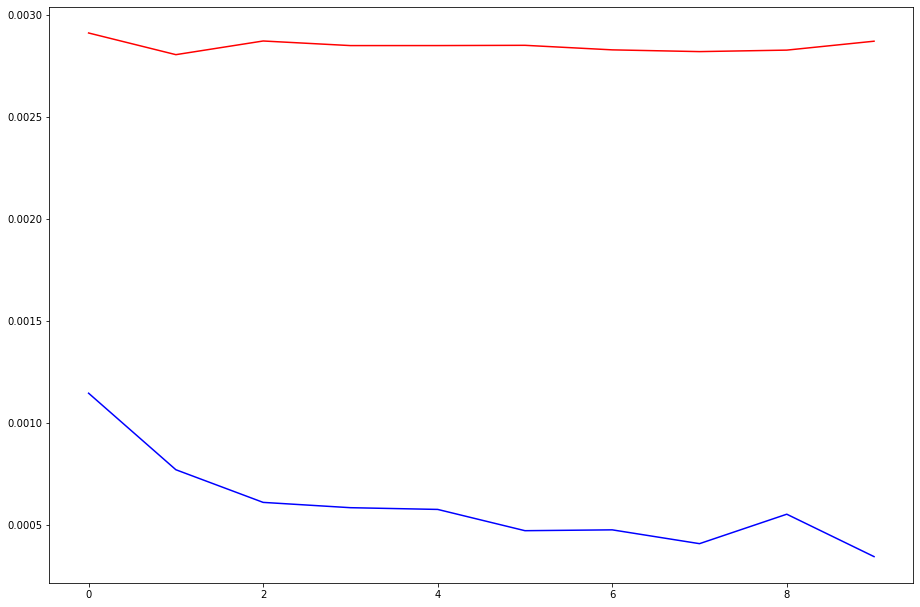

In [21]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [22]:
model = models.densenet201(pretrained=True)

model.classifier = torch.nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

<All keys matched successfully>

In [23]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=20, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 24min 20s


In [24]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [25]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename        model     filter   point  \
0       b0957dd6-caf5-4963-b0d8-05bc9ab2c652  densenet201  normalize  Point2   
1       de83aa99-f0b9-4f0d-99bf-30b8aaa8710c  densenet201  normalize  Point2   
2       a42d7a87-5fe3-4469-ac0b-513835c397c2  densenet201  normalize  Point2   
3       025a4be9-29f6-4eb4-8e79-8eaa4d36f008  densenet201  normalize  Point2   
4       60c0b75a-e037-4be3-ae00-0358cb9cc08a  densenet201  normalize  Point2   
...                                      ...          ...        ...     ...   
528315  d412d66a-2a1b-431d-acd2-622b50130bf4  densenet201  normalize  Point2   
528316  9458d718-cdb9-4478-923f-a8732c34142a  densenet201  normalize  Point2   
528317  e4103b5f-ba90-435a-8b43-d27b132bf405  densenet201  normalize  Point2   
528318  a09cd5ca-5e68-4273-8a57-ff0f554848ad  densenet201  normalize  Point2   
528319  148923f4-7f14-4f64-9f5a-48cffa4a6405  densenet201  normalize  Point2   

        v   predict  sign  
0       0  0.000120  -1.0  
1       0  0.000098  -1.0  
2       0  0.000132  -1.0  
3       0  0.999653   1.0  
4       0  0.000117  -1.0  
...    ..       ...   ...  
528315  3  0.000085  -1.0  
528316  3  0.000088   0.0  
528317  3  0.000145  -1.0  
528318  3  0.000160  -1.0  
528319  3  0.000145  -1.0  

[528320 rows x 7 columns]

In [26]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)